In [ ]:
clear

## Caricamento Dati

La seguente funzione permette di caricare matrici sparse, provenienti dal sito [https://sparse.tamu.edu/](https://sparse.tamu.edu/), salvate su file nel formato matlab.<br>
Questa funzione riesce a gestire sia i vecchi formati (`< matlab v7.3`) che quelli nuovi.

In [ ]:
function A = loadFunctionFromData(dataPath)
    disp(["🦍 Loading file: "  dataPath])
    load(dataPath)
    
%   se nel file è presente una `struct` allora vuol dire 
%   che sto utilizzando il nuovo formato e va convertito
%   per essere utilizzato da Octave
    if isstruct(Problem.A)
        n = length(Problem.A.jc)-1;
        ii = repelems(1:n, [1:n; diff(Problem.A.jc)]);
        A = sparse(Problem.A.ir+1, ii, Problem.A.data);
    else
        A = Problem.A;
    end
endfunction

In [ ]:
% Esempio di come utilizzare la precedente funzione
% whos
% A = loadFunctionFromData('./data/cage15.mat');
% columns(A)
% rows(A)
% clear
% A = loadFunctionFromData('./data/vas_stokes_2M.mat');
% columns(A)
% rows(A)

La seguente funzione genera i dati iniziali per poter utilizzare GMRES.

In [ ]:
function [A b x0] = generateData(dim, den, seed=69, randx0=false)
    rand("seed", seed);
    A = sprand(dim, dim, den);
    b = rand(dim, 1);
    
    if (randx0)
        x0 = rand(dim, 1);
    else
        x0 = zeros(dim, 1);
    end
endfunction

GMRES function

In [88]:
function [x res] = caagmres(A, b, x0, k, tol)
    n = size(b)(1);
    r0 = b - A * x0;
    beta = norm(r0, 2);
    
    H = zeros(k+2, k+1);
    Q = zeros(n, k+1);
    Q(:, 1) = r0/norm(r0, 2);
    
    en = zeros(k+2, 1);
    en(1) = 1;

    for j = 1:k  %% TODO: ricontrollare
%         imagesc(H);
        v = A*Q(:, j);   
        for i = 1:j
            H(i,j) = Q(:,i)' * v;
            v = v - H(i, j) * Q(:, i);
        end
        
        H(j+1, j) = norm(v, 2);
        Q(:, j+1) = v / H(j+1, j);

%         if (abs(H(j+1, j)) > tol)
%             Q(:, j+1) = Q(:,j+1)/H(j+1,j);
%         end
        
        e1 = en(1:j+2);

        y =(H(1:j+2,1:j+1))\(beta *e1);
        res(j) = norm(H(1:j+2,1:j+1)*y - beta*e1, 2);

        if (res(j) < tol)
            x = Q(:, 1:j+1)*y +x0;
            disp('Raggiunta Tolleranza, stop 🚀');
            imshow(H);
            return;
        end
    end
    x = Q(:, 1:j+1)*y +x0;
    disp('Raggiunto massimo numero di Iterazioni 🐌');
    imagesc(H);

endfunction

In [89]:
[A, b, x0] = generateData(100, .5);

In [90]:
% A
% b
% x0

Raggiunto massimo numero di Iterazioni 🐌


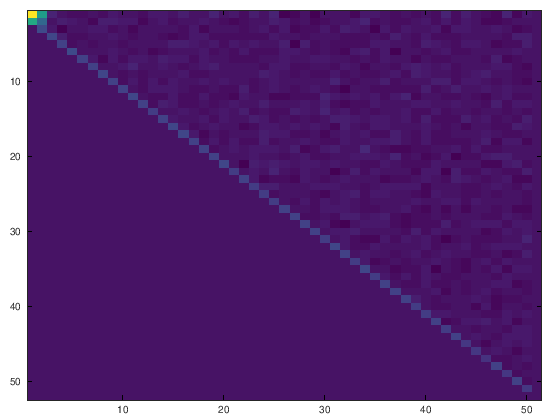

In [91]:
[x, res] = caagmres(A, b, x0, 50, 1e-10);

In [92]:
x
x_true = A\b
max(x_true-x)

x =

  -0.0201923
  -0.0677891
   0.1199244
   0.0638064
   0.1677747
  -0.0494033
   0.0825329
  -0.0263160
  -0.0616848
  -0.1179525
   0.0127384
   0.0479075
   0.1265152
  -0.1259734
  -0.0137531
  -0.0670265
   0.0814470
  -0.0728190
   0.0215602
   0.0893996
   0.1263778
   0.0108318
  -0.0869232
   0.0277875
   0.1175121
  -0.0898482
  -0.2354256
  -0.0033759
  -0.1250862
   0.0109098
  -0.1279142
  -0.0911171
   0.1101191
   0.0772024
   0.1906641
  -0.0197818
   0.0279160
   0.0511314
   0.1755224
  -0.0674799
  -0.0158713
   0.0910620
  -0.0110371
   0.0350522
   0.1752642
   0.0278794
  -0.0420496
  -0.1457358
   0.1957030
   0.1857568
   0.0484452
   0.0387626
  -0.1206017
  -0.0174932
  -0.0822885
   0.1203418
   0.0244209
   0.0784664
  -0.1172218
  -0.0267162
  -0.1167860
   0.0270275
   0.2514438
  -0.0949771
   0.0132733
   0.1703041
  -0.0917698
   0.0504087
  -0.0201117
   0.0528405
   0.1580686
  -0.0849125
   0.0733492
   0.0069045
   0.0314163
  -0.1323591
   0.09

In [93]:
whos

Variables in the current scope:

   Attr Name         Size                     Bytes  Class
   ==== ====         ====                     =====  ===== 
        A          100x100                    60404  double
        ans          1x1                          8  double
        b          100x1                        800  double
        res          1x50                       400  double
        trueres     20x1                        160  double
        x          100x1                        800  double
        x0         100x1                        800  double
        x_true     100x1                        800  double

Total is 10471 elements using 64172 bytes



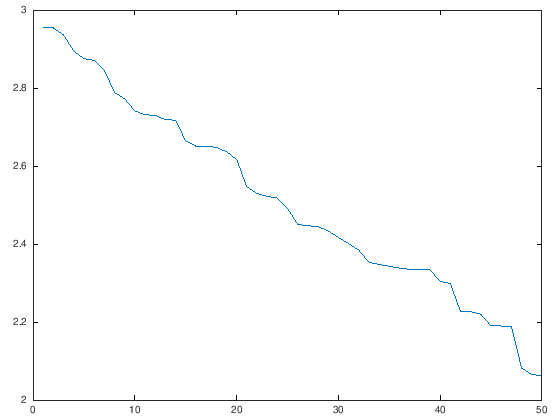

In [94]:
% subplot(2, 1, 1)
% plot(res);
% subplot(2, 1, 2)
% semilogy(res);
plot(res);

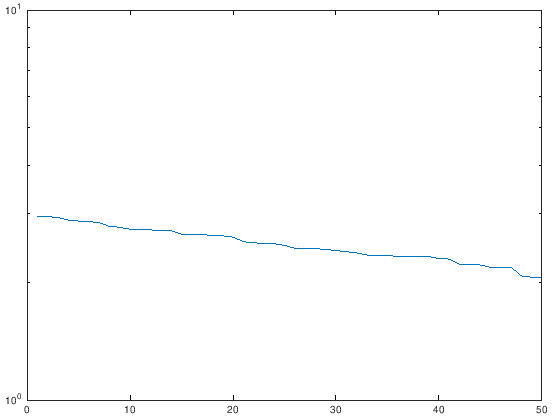

In [95]:
semilogy(res);

In [ ]:
function [Q, H, breakdown] = ANROLDI(A, b,Qold, Hold, n, tol)
    Hold
    if any(Hold) || isempty(Hold)
        H = [0 0]'
    else
%         H = [Hold 0;
%              0 0];
        H = [Hold zeros(size(Hold, 1), 1);
            zeros(1, size(Hold, 2) + 1)];
    end
    
    Q = [Qold  zeros(size(Qold, 1), 1)];
%     Qold
    w = A * Q(:, n);
    
    for i = max(1, n-1):n
        H(i, n) = Q(:, i)' * w;
        w = w - H(i, n) * Q(:, i);
    end
    w
    H(n+1, n) = norm(w);
    breakdown = norm(H(n+1, n)) < tol;
    Q(:, n+1) = w/norm(w);
endfunction

In [ ]:
function [x res] = altrogmres(A, b, x0, k, tol)
    Q = ones(size(b, 1), size(b, 1));
%     Q = zeros(;
    H = [];
    r0 = b - A * x0;
    beta = norm(r0, 2);
    e1 = zeros(size(b, 1), 1);
    e1(1) = 1;
    res = 0;
    for j=1:k
        [Q, H, breakdown] = ANROLDI(A, b, Q, H, j, tol);
        
        if (abs(H(j+1, j)) > tol)
            Q(:, j+1) = Q(:,j+1)/H(j+1,j);
        end
        
        e1 = zeros(j+1, 1);
        e1(1) = 1;

%         y =(H(1:j+2,1:j+1))\(beta *e1);
        y =H\(beta *e1(1:j+1));
%         res = norm(H(1:j+1,1:j)*y - beta*e1, 2);
        x = Q(:, 1:j) * y
%         disp(H(j+1,j))
%         disp(e1(1:j+1)*y)
%         res = (H(j+1,j) * abs(e1*y))/beta;
%         if (res < tol)
%             disp('Raggiunta toll');
%             x = Q(:, 1:j+1)*y +x0;
%             return;
%         end
    end
endfunction


In [ ]:
[x res] = altrogmres(A, b, x0, 10, 1e-10);

In [ ]:
isempty([])
all([1 2 30])
any([0 0 0])
2 < 4
any([])

In [ ]:
x
A\b

In [ ]:
t = [1 1 2;
     2 2 3;
     0 2 1;]

In [ ]:
[t zeros(size(t, 1), 1);
    zeros(1, size(t, 2) + 1)]

In [ ]:
size(t, 2)

In [ ]:
x
real_x = A\b
max(real_x - x)

In [ ]:
imshow(A);

In [ ]:
test = [1 1 1 0 0;
        0 1 1 1 0;
        0 0 1 1 1;
        0 0 0 1 1;]

In [ ]:
imshow(test);

In [ ]:
a = size([1 2 3])(2)

In [ ]:
dim = 20;
A = sprand(dim, dim, .5);
b = rand(dim, 1);
x0 = zeros(dim, 1);

In [ ]:
rand("seed", 20);


In [ ]:
real_res = A\b;

In [ ]:
real_res - x

In [ ]:
max(real_res- x )

In [ ]:
rand(1, 3)

In [ ]:
rand(3, 1)

In [ ]:
rand(3)

In [ ]:
zeros(3, 1)

In [ ]:
function [x res] = cgmres(A, b, x0, k, tol)
    n = size(b)(1);
    Q = zeros(n, k+1);
    H = zeros(k+1, k);
    r0 = b - A * x0;
    beta = norm(r0, 2);
    Q(:, 1) = r0/norm(r0, 2);
%     e1 = zeros(n, 1);
%     e1(1) = 1;
%     e1 = e1';
    for j = 1:k  %% TODO: ricontrollare
        imagesc(H);
        disp(j);
        
        Q(:,j+1) = A * Q(:, j);
        
        for i = 1:j
            H(i,j) = Q(:,i)' * Q(:, j+1);
            Q(:, j+1) = Q(:, j+1) - H(i,j) * Q(:,i);
        end
        
        H(j+1, j) = norm(Q(:, j+1), 2);
        
        if (abs(H(j+1, j)) > tol)
            Q(:, j+1) = Q(:,j+1)/H(j+1,j);
        end
        
        e1 = zeros(j+2, 1);
        e1(1) = 1;
%         e1 = e1';
        %%TODO: ricontrollare
%         y=0
        y =(H(1:j+2,1:j+1))\(beta *e1);
        res = norm(H(1:j+2,1:j+1)*y - beta*e1, 2);
        
        if (res < tol)
            disp('Raggiunta toll');
            x = Q(:, 1:j+1)*y +x0;
            return;
        end
    end
    x = Q(:, 1:j+1)*y +x0;
%     return;   % potrebbe essere superfluo
endfunction